In [0]:
print(device)

/gpu:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Pcam/train.zip", 'r')
zip_ref2 = zipfile.ZipFile("/content/drive/My Drive/Pcam/test.zip", 'r')
#zip_ref2 = zipfile.ZipFile("/content/drive/My Drive/Pcam/test.zip", 'r')
zip_ref.extractall('./train/')
zip_ref2.extractall('./test/')
#!ln -s "/content/drive/My Drive/path_to_folder_desired" "/path/to/the_folder/you created /train
zip_ref.close()
zip_ref2.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import os
from sklearn.metrics import f1_score

from fastai import *
from fastai.vision import *

import torch
import torch.nn as nn
import torchvision
import cv2
import random

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings("ignore")


In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)
labels_path = 'train_labels.csv'
train_path = '/train/'
test_path = '/content/test/test/'
sz = 96
BATCH_SIZE = 128 
data = ImageDataBunch.from_csv('../content/',csv_labels=labels_path,folder=train_path, ds_tfms=tfms, size=sz, suffix='.tif',test=test_path,bs=BATCH_SIZE);
stats=data.batch_stats()        
data.normalize(stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,1
Path: ../content;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,1,1,1,1
Path: ../content;

Test: LabelList (57458 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: ../content

In [0]:
learner = create_cnn(
    data,
    models.resnet18, 
#    pretrained=True,
    path='.',    
    metrics=accuracy,
    ps=0.5,
   # callback_fns=ShowGraph
)

NameError: ignored

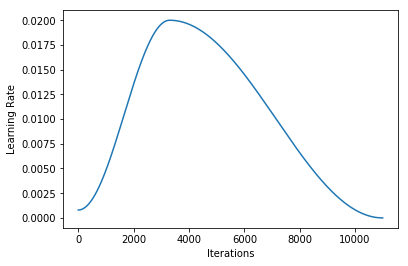

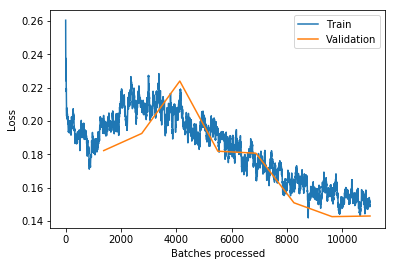

In [0]:
#Before LR fine-tuning
# and plot the losses of the first cycle to check if the model is learning
max_lr = 2e-2   #We can select the learning rate around 2e-2 where it is close to the bottom but still descending.
wd = 1e-4
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)   #before finetuning
#learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))  #after finetuning


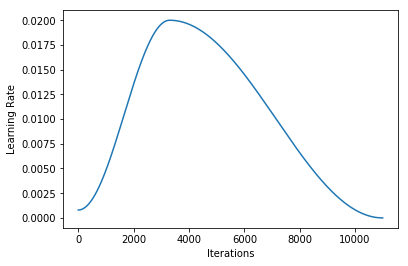

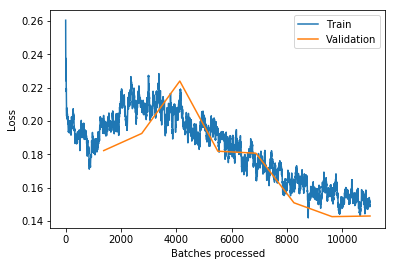

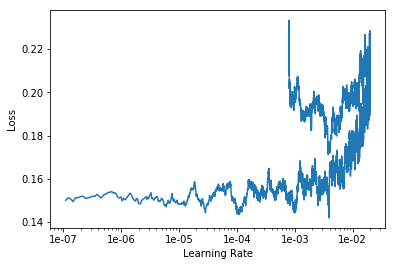

In [0]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

# and plot the losses of the first cycle to check that the model is learning
learner.recorder.plot_losses() 

#
learner.recorder.plot()

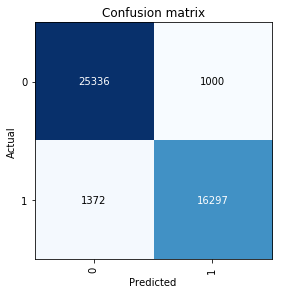

In [0]:
#Confusion matrix of the baseline model and save the baselinemodel
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

learner.save(MODEL_PATH + '_stage1new')

In [0]:
# Accuracy on Validation Set
preds, y,loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The validation set accuracy is {0} %.'.format(acc))

The valiidation set accuracy is 0.9460970163345337 %.


In [0]:
# Accuracy on TestSet
preds, y,loss = learner.get_preds(DatasetType.Test,with_loss=True)
#preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test)
# get accuracy
acc = accuracy(preds, y)
print('The test set accuracy is {0} %.'.format(acc))



The test set accuracy is 0.6500400304794312 %.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


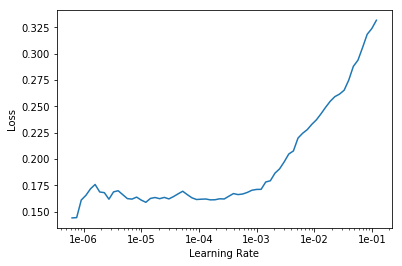

In [0]:
#Finetuning
# unfreeze and run learning rate finder again
#learner.load('/resnet18_stage1new')
learner.unfreeze()
wd=1e-4
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

In [0]:
#After LR finetuning with smaller learning rates. This time we define the min and max lr of the cycle
#From the above plot, choose max and min of lr to be 1e-05 to 1e-04

learner.fit_one_cycle(cyc_len=5, max_lr=slice(1e-5,1e-4))  #after finetuning

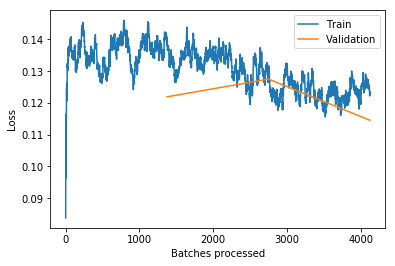

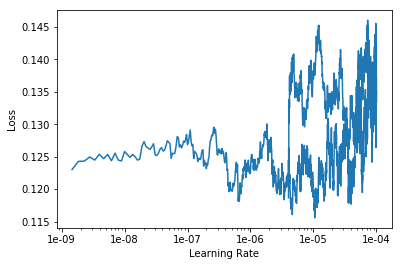

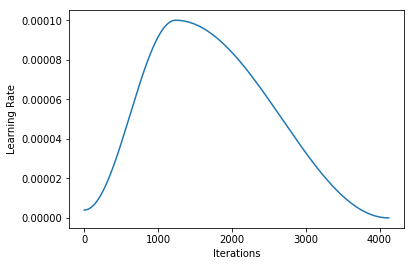

In [0]:
# and plot the losses of the first cycle to check that the model is learning
learner.recorder.plot_losses()

#
learner.recorder.plot()

## plot learning rate of the one cycle
learner.recorder.plot_lr()

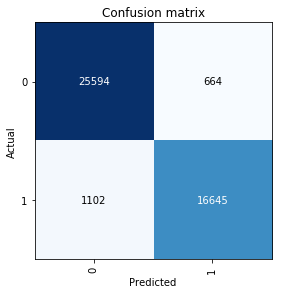

In [0]:
# New confusion matrix of lr-finetuned model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [0]:
# If the fine-tuned model was better than the baseline one, save the finetuned model
learner.save('resnet18_stage2new')

# if the model was better before finetuning, uncomment this to load the previous stage
#learner.load(MODEL_PATH + '_stage1')

In [0]:
#Accuracy of the best model (i.e: fine-tuned) on validation
learner.load('/content/models/resnet18_stage2new')
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy validation is {0} %.'.format(acc))

The accuracy validation is 0.953323483467102 %.


In [0]:
#Accuracy of the best model (i.e: fine-tuned) on testset
learner.load('/content/models/resnet18_stage2new')
preds_test, y_test,loss_test = learner.get_preds(DatasetType.Test,with_loss=True)
#preds_test = torch.argmax(preds_test, dim=1)
print(torch.unique(y_test))
# get accuracy
acc_test = accuracy(preds_test, y_test)
print('The accuracy test set is {0} %.'.format(acc_test))

tensor([0])
The accuracy test set is 0.6666608452796936 %.


In [0]:
# VISUALIZATION FUNCTION FOR VALIDATION SET
from random import randint

def plot_TP(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
#    fig, ax = plt.subplots(3,4, figsize=(16,12))
#    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random True Positive
    img_list = []
    class_list = []
    count = 0
    for TF_index in range(0,len(tl_idx)):
          idx = tl_idx[TF_index]
         # print('idx',idx)
  #        print('count',len(class_list),len(img_list))   to debug
          im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
          if classes[interp.pred_class[idx]] == 'Tumor' and classes[int(cl)]=='Tumor':
             if len(class_list)>=0 and len(class_list)<=59:
               img_list.append(image2np(im.data))
               im = image2np(im.data)
               cl = int(cl)
               class_list.append(cl)
        #       print('count',len(class_list),len(img_list))
             else:
        #       print('count',len(class_list),len(img_list))
               plt.figure(figsize = (12*2,5*2))
               plt.tight_layout()
               for chart, img in enumerate(img_list,1):
                 #  print('chart',chart)
                 #  fig = plt.figure()
                   ax = plt.subplot(5,12,chart)   #rows: no.of plots per rows ' #cols: no.of plots per column'
                   ax.imshow(np.array(img))
                   ax.axis('off')
                   plt.savefig('TP_plot.jpg')
                  # fig.savefig('plot.png')
               return

def plot_TN(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
#    fig, ax = plt.subplots(3,4, figsize=(16,12))
#    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random True Positive
    img_list = []
    class_list = []
    count = 0
    for TF_index in range(0,len(tl_idx)):
          idx = tl_idx[TF_index]
         # print('idx',idx)
#          print('count',len(class_list),len(img_list)) to debug
          im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
          if classes[interp.pred_class[idx]] == 'Negative' and classes[int(cl)]=='Negative':
             if len(class_list)>=0 and len(class_list)<=59:
               img_list.append(image2np(im.data))
               im = image2np(im.data)
               cl = int(cl)
               class_list.append(cl)
        #       print('count',len(class_list),len(img_list))
             else:
        #       print('count',len(class_list),len(img_list))
               plt.figure(figsize = (12*2,5*2))
               plt.tight_layout()
               for chart, img in enumerate(img_list,1):
                  # print('chart',chart)
                 #  fig = plt.figure()
                   ax = plt.subplot(5,12,chart)   #rows: no.of plots per rows ' #cols: no.of plots per column'
                   ax.imshow(np.array(img))
                   ax.axis('off')
                   plt.savefig('TN_plot.jpg')
                  # fig.savefig('plot.png')
               return
      
 
def plot_FP(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
#    fig, ax = plt.subplots(3,4, figsize=(16,12))
#    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random True Positive
    img_list = []
    class_list = []
    count = 0
    for TF_index in range(0,len(tl_idx)):
          idx = tl_idx[TF_index]
         # print('idx',idx)
#          print('count',len(class_list),len(img_list)) to debug
          im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
          if classes[interp.pred_class[idx]] == 'Tumor' and classes[int(cl)]=='Negative':
             if len(class_list)>=0 and len(class_list)<=59:
               img_list.append(image2np(im.data))
               im = image2np(im.data)
               cl = int(cl)
               class_list.append(cl)
        #       print('count',len(class_list),len(img_list))
             else:
         #      print('count',len(class_list),len(img_list))
               plt.figure(figsize = (12*2,5*2))
               plt.tight_layout()
               for chart, img in enumerate(img_list,1):
                 #  print('chart',chart)
                 #  fig = plt.figure()
                   ax = plt.subplot(5,12,chart)   #rows: no.of plots per rows ' #cols: no.of plots per column'
                   ax.imshow(np.array(img))
                   ax.axis('off')
                   plt.savefig('FP_plot.jpg')
                  # fig.savefig('plot.png')
               return    
            
            
def plot_FN(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
#    fig, ax = plt.subplots(3,4, figsize=(16,12))
#    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random True Positive
    img_list = []
    class_list = []
    count = 0
    for TF_index in range(0,len(tl_idx)):
          idx = tl_idx[TF_index]
         # print('idx',idx)
#          print('count',len(class_list),len(img_list)) to debug
          im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
          if classes[interp.pred_class[idx]] == 'Negative' and classes[int(cl)]=='Tumor':
             if len(class_list)>=0 and len(class_list)<=59:
               img_list.append(image2np(im.data))
               im = image2np(im.data)
               cl = int(cl)
               class_list.append(cl)
        #       print('count',len(class_list),len(img_list))
             else:
       #        print('count',len(class_list),len(img_list))
               plt.figure(figsize = (12*2,5*2))
               plt.tight_layout()
               for chart, img in enumerate(img_list,1):
                #   print('chart',chart)
                 #  fig = plt.figure()
                   ax = plt.subplot(5,12,chart)   #rows: no.of plots per rows ' #cols: no.of plots per column'
                   ax.imshow(np.array(img))
                   ax.axis('off')
                   plt.savefig('FN_plot.jpg')
                  # fig.savefig('plot.png')
               return    
           

In [0]:
#Visaluzation for Validation Set
interp_val = ClassificationInterpretation.from_learner(learner)


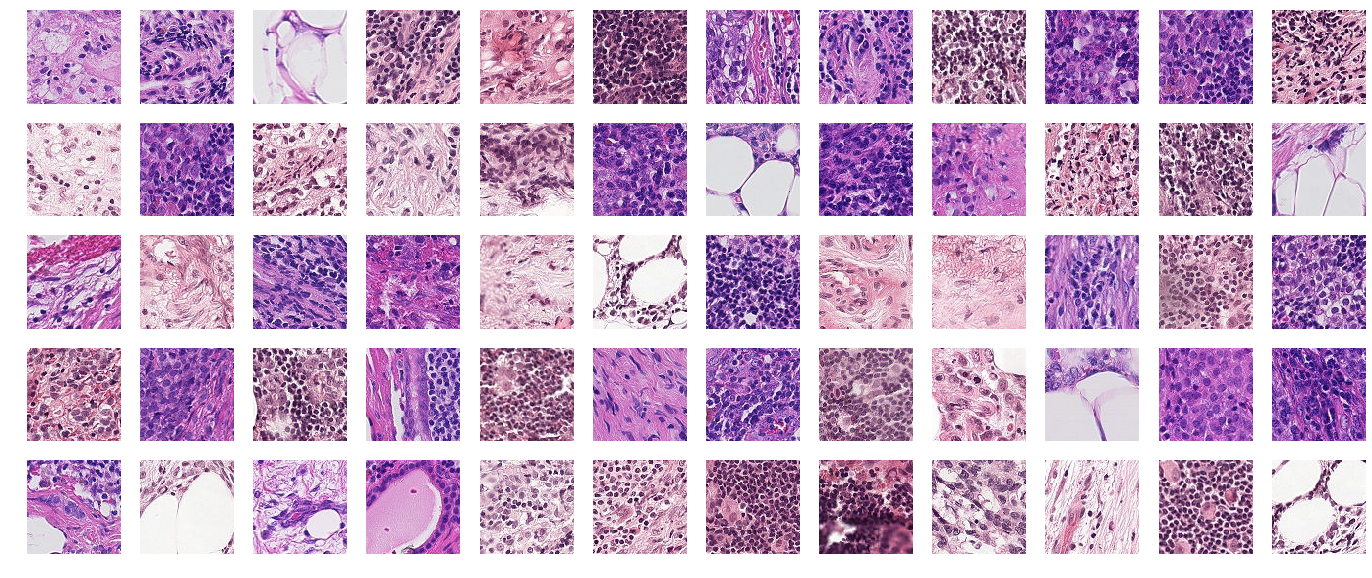

In [0]:
# Plot True Positive from validation
plot_TP(interp_val, ['Negative','Tumor'])



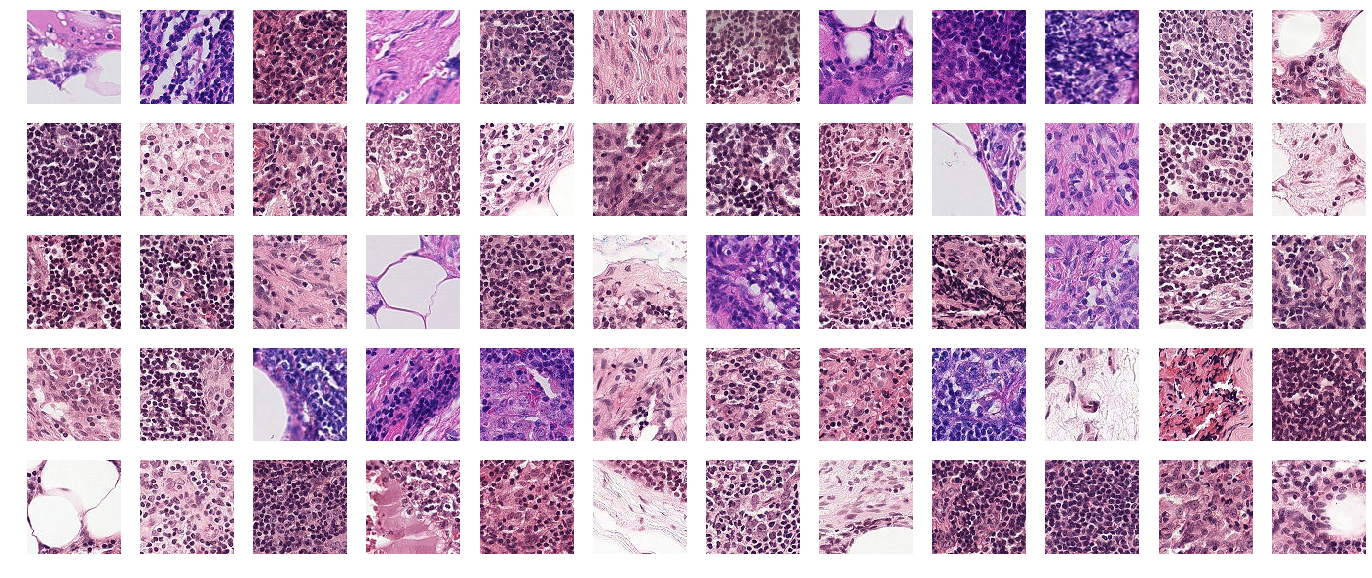

In [0]:
# Plot True Negative
plot_TN(interp_val, ['Negative','Tumor'])



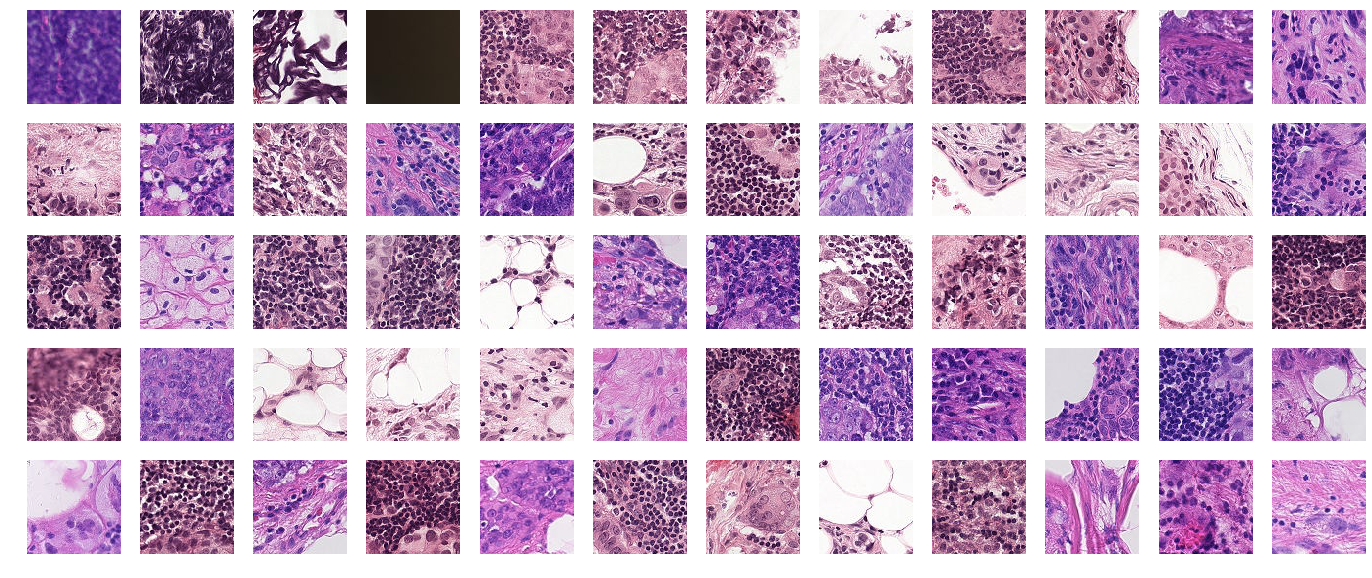

In [0]:
# Plot False Positive
plot_FP(interp_val, ['Negative','Tumor'])



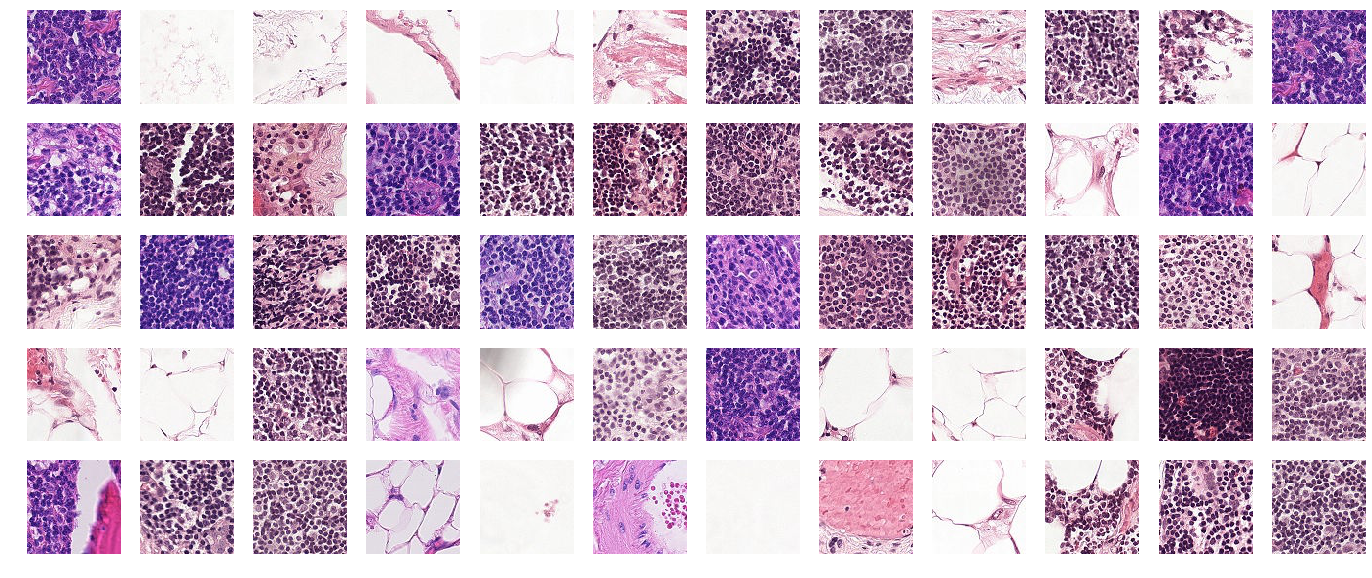

In [0]:
# Plot False Negative
plot_FN(interp_val, ['Negative','Tumor'])

In [0]:
#Visualization for Test set: NOT WORKING
# Plot overview function, adapted from fast ai plot_top_losses
from random import randint

def plot_TP(interp_test:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all ds_type losses and indexes sorted by the largest first
    tl_val,tl_idx = interp_test.top_losses()
    print('enter tp')
    img_list = []
    class_list = []
    count = 0
    for TF_index in range(0,len(tl_idx)):
          idx = tl_idx[TF_index]
          im,cl = interp_test.data.dl(DatasetType.Test).dataset[idx]
          cl=y_test[idx]
    
          print(classes[interp_test.pred_class[idx]])
          print(classes[int(cl)])
          if classes[interp_test.pred_class[idx]] == 'Tumor' and classes[int(cl)]=='Tumor':
             if len(class_list)>=0 and len(class_list)<=59:
               img_list.append(image2np(im.data))
               im = image2np(im.data)
               cl = int(cl)
               class_list.append(cl)
            #   print('count',len(class_list),len(img_list))
             else:
            #   print('count',len(class_list),len(img_list))
               plt.figure(figsize = (12*2,5*2))
               plt.tight_layout()
               for chart, img in enumerate(img_list,1):
             #      print('chart',chart)
                 #  fig = plt.figure()
                   ax = plt.subplot(5,12,chart)   #rows: no.of plots per rows ' #cols: no.of plots per column'
                   ax.imshow(np.array(img))
                   ax.axis('off')
                   plt.savefig('TP_plot_test.jpg')
                  # fig.savefig('plot.png')
               print('finish running TP')
               return

def plot_TN(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all ds_type losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    img_list = []
    class_list = []
    count = 0
    for TF_index in range(0,len(tl_idx)):
          idx = tl_idx[TF_index]
#          print('count',len(class_list),len(img_list)) to debug
       
          im,cl = interp.data.dl(DatasetType.Test).dataset[idx]
          cl=y_test[idx]
          if classes[interp.pred_class[idx]] == 'Negative' and classes[int(cl)]=='Negative':
             if len(class_list)>=0 and len(class_list)<=59:
               img_list.append(image2np(im.data))
               im = image2np(im.data)
               cl = int(cl)
               class_list.append(cl)
           #    print('count',len(class_list),len(img_list))
             else:
           #    print('count',len(class_list),len(img_list))
               plt.figure(figsize = (12*2,5*2))
               plt.tight_layout()
               for chart, img in enumerate(img_list,1):
               #    print('chart',chart)
                 #  fig = plt.figure()
                   ax = plt.subplot(5,12,chart)   #rows: no.of plots per rows ' #cols: no.of plots per column'
                   ax.imshow(np.array(img))
                   ax.axis('off')
                   plt.savefig('TN_plot_test.jpg')
                  # fig.savefig('plot.png')
               return
      
 
def plot_FP(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
#    fig, ax = plt.subplots(3,4, figsize=(16,12))
#    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random True Positive
    img_list = []
    class_list = []
    count = 0
    for TF_index in range(0,len(tl_idx)):
          idx = tl_idx[TF_index]
         # print('idx',idx)
#          print('count',len(class_list),len(img_list)) to debug
          im,cl = interp.data.dl(DatasetType.Test).dataset[idx]
          cl=y_test[idx]
          print(classes[interp_test.pred_class[idx]])
          print(classes[int(cl)])
          if classes[interp.pred_class[idx]] == 'Tumor' and classes[int(cl)]=='Negative':
             if len(class_list)>=0 and len(class_list)<=59:
               img_list.append(image2np(im.data))
               im = image2np(im.data)
               cl = int(cl)
               class_list.append(cl)
        #       print('count',len(class_list),len(img_list))
             else:
        #       print('count',len(class_list),len(img_list))
               plt.figure(figsize = (12*2,5*2))
               plt.tight_layout()
               for chart, img in enumerate(img_list,1):
              #     print('chart',chart)
                 #  fig = plt.figure()
                   ax = plt.subplot(5,12,chart)   #rows: no.of plots per rows ' #cols: no.of plots per column'
                   ax.imshow(np.array(img))
                   ax.axis('off')
                   plt.savefig('FP_plot_test.jpg')
                  # fig.savefig('plot.png')
               return    
            
            
def plot_FN(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    img_list = []
    class_list = []
    count = 0
    for TF_index in range(0,len(tl_idx)):
          idx = tl_idx[TF_index]
         
#          print('count',len(class_list),len(img_list)) to debug
          im,cl = interp.data.dl(DatasetType.Test).dataset[idx]
          cl=y_test[idx]
          print(classes[interp_test.pred_class[idx]])
          print(classes[int(cl)])
          if classes[interp.pred_class[idx]] == 'Negative' and classes[int(cl)]=='Tumor':
             if len(class_list)>=0 and len(class_list)<=59:
               img_list.append(image2np(im.data))
               im = image2np(im.data)
               cl = int(cl)
               class_list.append(cl)
        #       print('count',len(class_list),len(img_list))
             else:
        #       print('count',len(class_list),len(img_list))
               plt.figure(figsize = (12*2,5*2))
               plt.tight_layout()
               for chart, img in enumerate(img_list,1):
        #           print('chart',chart)
                 #  fig = plt.figure()
                   ax = plt.subplot(5,12,chart)   #rows: no.of plots per rows ' #cols: no.of plots per column'
                   ax.imshow(np.array(img))
                   ax.axis('off')
                   plt.savefig('FN_plot_test.jpg')
                  # fig.savefig('plot.png')
               return    
           
interp_test = ClassificationInterpretation.from_learner(learner,ds_type=DatasetType.Test)
#interp_test = ClassificationInterpretation.from_learner(learner,ds_type=DatasetType.Test)
# Plot True Positive from validation
plot_TP(interp_test, ['Negative','Tumor'])

# Plot True Negative
plot_TN(interp_test, ['Negative','Tumor'])

# Plot False Positive
plot_FP(interp_test, ['Negative','Tumor'])

# Plot False Negative
plot_FN(interp_test, ['Negative','Tumor'])

probs_test tensor([8.7052e-01, 6.8737e-04, 8.9027e-01,  ..., 4.1728e-03, 1.5820e-05,
        2.5921e-04])
y_test torch.Size([57458])
ROC area is 0.9914929467298728


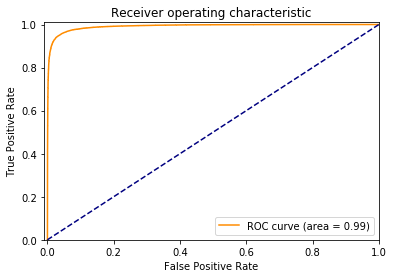

In [0]:
#ROC Curve and AUC curve for validation set
#preds_test, y_test

from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
#probs = preds[:,1]
print('probs_test',probs_test)
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
print('y_test',y_test.shape)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

#

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [0]:
from sklearn.metrics import roc_auc_score
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score
  
pred_score=auc_score(preds,y)
pred_score

tensor(0.9915)

In [0]:
#Convert test prediction to csv
print('preds',preds.shape)   #Negative and Tumor Probabilities: [9.999999e-01 9.291228e-08]
#preds2 = int(preds[0])
tumor_preds = preds[:,1]

tumor_pred_list = tumor_preds.tolist()
actual_y_list = y.tolist()
df_pred = pd.DataFrame({'TRUE':actual_y_list,'pred':tumor_pred_list})

# Export to csv
df_pred.to_csv('prediction_val.csv', header=True, index=False)

print('turmor_preds',tumor_preds)
print('actual y',y.shape)

preds torch.Size([44005, 2])
turmor_preds tensor([0.9961, 0.9999, 0.9861,  ..., 0.9606, 0.0710, 0.0703])
actual y torch.Size([44005])


In [0]:
#count the number of labels in validation set
torch.unique(y)

tensor([0, 1])

In [0]:
df_pred_test

TRUE      pred
0         0  0.870524
1         0  0.000687
2         0  0.890265
3         0  0.000284
4         0  0.001397
5         0  0.008253
6         0  0.009120
7         0  0.000312
8         0  0.006575
9         0  0.013500
10        0  0.281911
11        0  0.137184
12        0  0.034757
13        0  0.205241
14        0  0.997054
15        0  0.000097
16        0  0.011168
17        0  0.030932
18        0  0.000814
19        0  0.603150
20        0  0.123476
21        0  0.001448
22        0  0.147910
23        0  0.008785
24        0  0.001496
25        0  0.534349
26        0  0.000009
27        0  0.001243
28        0  0.014948
29        0  0.951394
...     ...       ...
57428     0  0.002448
57429     0  0.002771
57430     0  0.947064
57431     0  0.004018
57432     0  0.000345
57433     0  0.006247
57434     0  0.004909
57435     0  0.000155
57436     0  0.004825
57437     0  0.002640
57438     0  0.927572
57439     0  0.016839
57440     0  0.028262
57441     0  0.131796
57442     0  0.756771
57443     0  0.918022
57444     0  0.928127
57445     0  0.700270
57446     0  0.939390
57447     0  0.263059
57448     0  0.003457
57449     0  0.000057
57450     0  0.605192
57451     0  0.673842
57452     0  0.287493
57453     0  0.004979
57454     0  0.002416
57455     0  0.004173
57456     0  0.000016
57457     0  0.000259

[57458 rows x 2 columns]